# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import logging
import os
import sys
import tempfile
import time
from pathlib import Path

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
import pingouin as pg
from okabeito import black, blue, green, lightblue, orange, purple, red, yellow
from seaborn import axes_style


In [2]:
from pythoneeg import constants, core, visualization

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tempdir = Path('../../tmp').resolve()
print(tempdir)
core.set_temp_directory(tempdir)

/mnt/isilon/marsh_single_unit/PythonEEG/tmp


In [4]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.WARNING, stream=sys.stdout, force=True)
logger = logging.getLogger()

In [5]:
base_folder = Path("/mnt/isilon/marsh_single_unit/PythonEEG")
load_folder = base_folder / "notebooks" / "tests" / "test-wars-sox5-6"
animal_ids = [p.name for p in load_folder.glob("*") if p.is_dir()][:3]

In [6]:
def load_war(animal_id):
    logger.info(f"Loading {animal_id}")
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(load_folder / f"{animal_id}").resolve())
    if war.genotype == "Unknown":
        logger.info(f"Skipping {animal_id} because genotype is Unknown")
        return None

    war.filter_all(bad_channels=['LHip', 'RHip'])
    war.reorder_and_pad_channels(
        ["LMot", "RMot", "LBar", "RBar", "LAud", "RAud", "LVis", "RVis", "LHip", "RHip"], use_abbrevs=True
    )
    df = war.get_result(features=['psdband'])
    del war
    return df

In [7]:
# load_war(animal_ids[0])

In [33]:
df = pd.read_pickle("/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/examples/alphadelta_avg.pkl")
df = df.reset_index(drop=False)
df["sex"] = df["genotype"].str[0]
df["sex"] = df["sex"].map({"F": "Female", "M": "Male"})
df["genotype"] = df["genotype"].str[1:]
df.info()
df["alphadelta_avg_nobase"] = df.groupby(["animal", "genotype", "sex"]).apply(
    lambda g: g["alphadelta_avg"] - g.loc[
        (g["total_minutes"] <= 6*60) | (g["total_minutes"] >= 18*60), 
        "alphadelta_avg"
    ].mean()
).reset_index(level=[0,1,2], drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521 entries, 0 to 1520
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           1521 non-null   int64  
 1   animal          1521 non-null   object 
 2   genotype        1521 non-null   object 
 3   total_minutes   1521 non-null   float64
 4   alphadelta_avg  1521 non-null   float64
 5   sex             1521 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 71.4+ KB


/tmp/ipykernel_1525193/2393283347.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["alphadelta_avg_nobase"] = df.groupby(["animal", "genotype", "sex"]).apply(


In [34]:
df.head()

,index,animal,genotype,total_minutes,alphadelta_avg,sex,alphadelta_avg_nobase
0,0,#2 Cage 2A_fa775cf6debf6e09c372e6e81165f0f6585...,Mut,0.0,0.206999,Male,-0.016474
1,1,#2 Cage 2A_fa775cf6debf6e09c372e6e81165f0f6585...,Mut,60.0,0.215210,Male,-0.008264
2,2,#2 Cage 2A_fa775cf6debf6e09c372e6e81165f0f6585...,Mut,120.0,0.255636,Male,0.032163
3,3,#2 Cage 2A_fa775cf6debf6e09c372e6e81165f0f6585...,Mut,180.0,0.237797,Male,0.014323
4,4,#2 Cage 2A_fa775cf6debf6e09c372e6e81165f0f6585...,Mut,240.0,0.207764,Male,-0.015709


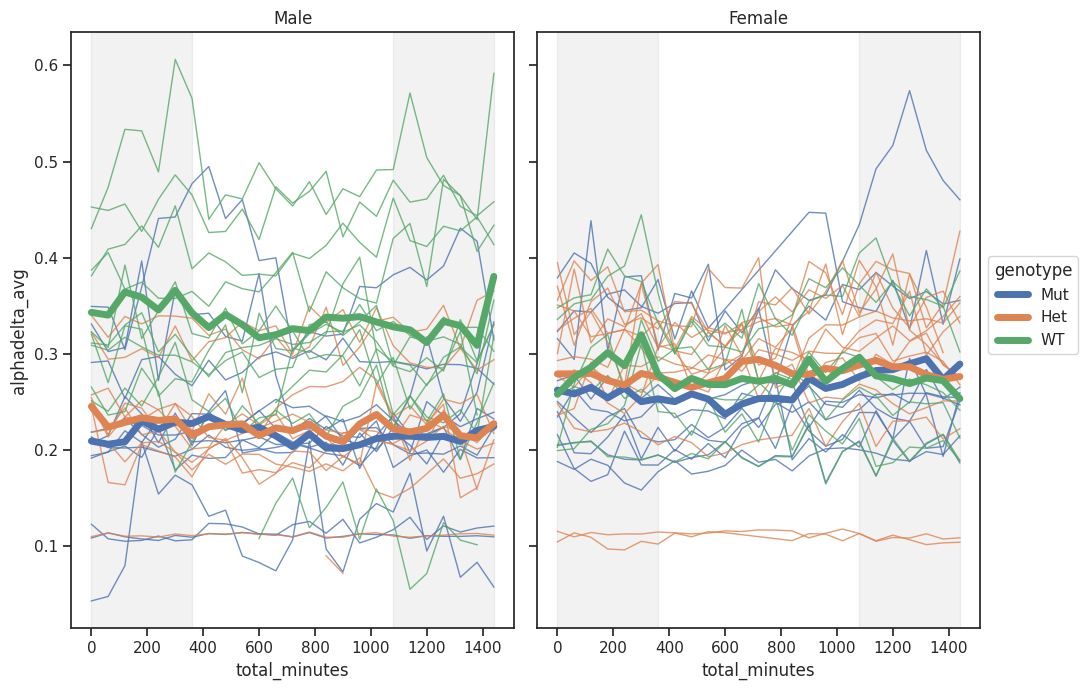

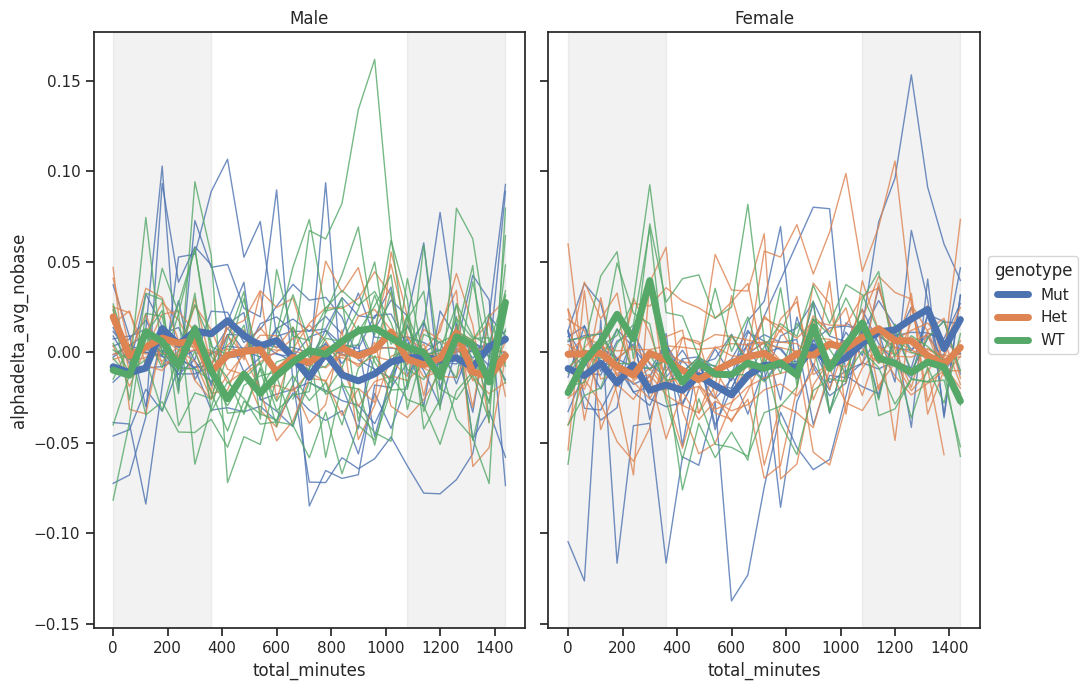

In [40]:
import matplotlib as mpl
for feature in ['alphadelta_avg', 'alphadelta_avg_nobase']:
    p = (  # fmt: off
        so.Plot(df, x="total_minutes", y=feature, color='genotype')  # fmt: off
        .facet(col='sex')
        .add(so.Lines(linewidth=1, alpha=0.8), group='animal')
        .add(so.Line(linewidth=5), so.Agg())
        # .add(so.Band(), so.Est())
        .layout(size=(10, 7))
        .theme(axes_style("ticks"))
    )
    fig = mpl.figure.Figure(figsize=(10, 7))
    p.on(fig).plot()
    for ax in fig.axes:
        ax.axvspan(xmin=0, xmax=6 * 60, alpha=0.1, color='grey')
        ax.axvspan(xmin=18 * 60, xmax=24 * 60, alpha=0.1, color='grey')
    fig.tight_layout()
    display(fig)
    plt.close()
